# Obter dataset a partir do API do Kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedro21afonso","key":"4a1430583be9a7d696719b804b21144b"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download "miljan/stanford-dogs-dataset-traintest"

Dataset URL: https://www.kaggle.com/datasets/miljan/stanford-dogs-dataset-traintest
License(s): other


In [4]:
!unzip stanford-dogs-dataset-traintest.zip -d /content/stanford-dogs-dataset-traintest

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_1066.jpg  
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_1140.jpg  
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_1200.jpg  
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_1270.jpg  
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_1299.jpg  
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_1318.jpg  
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_1409.jpg  
  inflating: /content/stanford-dogs-dataset-traintest/cropped/train/n02102973-Irish_water_spaniel/n02102973_

# Criar splits de treino, validação e teste

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import pandas as pd
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[1.0, 1.8],
    validation_split=0.2,
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [3]:
img_height = 224
img_width = 224
batch_size = 64
train_data_dir = '/content/stanford-dogs-dataset-traintest/cropped/train'
test_data_dir = '/content/stanford-dogs-dataset-traintest/cropped/test'

print('Train')
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='training',
    shuffle= True,
    seed= 1337
)

print('Valid')
valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='validation',
    shuffle= True,
    seed= 1337
)

print('Test')
test_generator = test_datagen.flow_from_directory(test_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    shuffle=False,
    seed= 1337)

Train
Found 9600 images belonging to 120 classes.
Valid
Found 2400 images belonging to 120 classes.
Test
Found 8580 images belonging to 120 classes.


# Obter nº de labels e preparar as labels

In [4]:
num_classes = len(train_generator.class_indices)

train_labels = train_generator.classes
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes
valid_labels = tf.keras.utils.to_categorical(valid_labels, num_classes=num_classes)
test_labels = test_generator.classes
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

nb_train_samples = len(train_generator.filenames)
nb_valid_samples = len(valid_generator.filenames)

class_labels = list(test_generator.class_indices.keys())

# Mostrar imagens com data augmentation

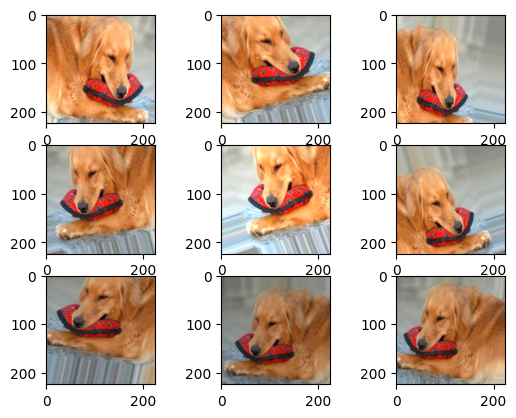

In [ ]:
img = tf.keras.preprocessing.image.load_img('/content/stanford-dogs-dataset-traintest/cropped/train/n02099601-golden_retriever/n02099601_10.jpg')
data = tf.keras.preprocessing.image.img_to_array(img)
samples = np.expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = next(it)
    image = batch[0]
    plt.imshow(image)

plt.show()

# Criação de modelo simples (CNN)

In [ ]:

model = tf.keras.Sequential([

  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D((2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,953,912 (49.42 MB)

 Trainable params: 12,953,912 (49.42 MB)

 Non-trainable params: 0 (0.00 B)

# Treinar modelo

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [earlystop, reduceLR]

history = model.fit(
    train_generator,
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator,
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 - 160s - 1s/step - accuracy: 0.0089 - loss: 4.7960 - val_accuracy: 0.0080 - val_loss: 4.7559 - learning_rate: 1.0000e-03
Epoch 2/30
150/150 - 191s - 1s/step - accuracy: 0.0147 - loss: 4.7150 - val_accuracy: 0.0182 - val_loss: 4.6084 - learning_rate: 1.0000e-03
Epoch 3/30
150/150 - 149s - 996ms/step - accuracy: 0.0178 - loss: 4.6052 - val_accuracy: 0.0249 - val_loss: 4.5207 - learning_rate: 1.0000e-03
Epoch 4/30
150/150 - 200s - 1s/step - accuracy: 0.0240 - loss: 4.5064 - val_accuracy: 0.0367 - val_loss: 4.3844 - learning_rate: 1.0000e-03
Epoch 5/30
150/150 - 148s - 984ms/step - accuracy: 0.0302 - loss: 4.4340 - val_accuracy: 0.0422 - val_loss: 4.2748 - learning_rate: 1.0000e-03
Epoch 6/30
150/150 - 147s - 977ms/step - accuracy: 0.0360 - loss: 4.3716 - val_accuracy: 0.0494 - val_loss: 4.2276 - learning_rate: 1.0000e-03
Epoch 7/30
150/150 - 203s - 1s/step - accuracy: 0.0398 - loss: 4.3248 - val_accuracy: 0.0553 - val_loss: 4.1561 - learning_rate: 1.0000e-03
Epoch 8/30


CNN simples com data augmentation 1h 24 min 50 s.

Se aumentasse nº de epochs talvez obtia melhor resultado

# Avaliar modelo

135/135 - 16s - 120ms/step - accuracy: 0.1270 - loss: 3.6427


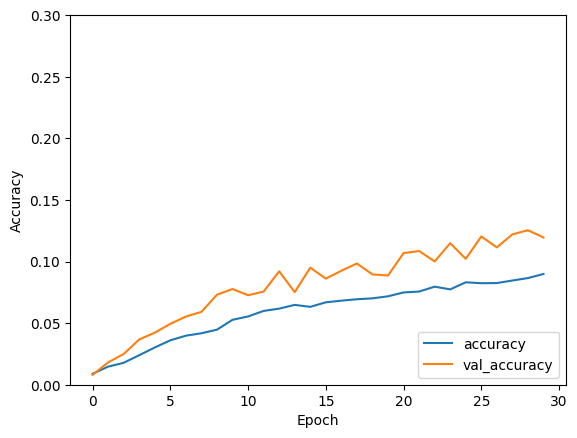

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.3])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_generator, verbose=2)

# Salvar modelo

In [ ]:
model.save('stanford-dogs-dataset-CNN.keras')

# Modelos Transfer Learning (InceptionV3)

In [ ]:
InceptionV3 = tf.keras.applications.InceptionV3(include_top= False, input_shape=(img_width, img_height, 3), weights= 'imagenet')
InceptionV3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
model = tf.keras.Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False

model.add(InceptionV3)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(120, activation='softmax'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │       245,880 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,048,664 (84.11 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto'
)

callbacks = [earlystop, reduceLR]

In [ ]:
history = model.fit(
    train_generator,
    epochs = 100,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator,
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
150/150 - 152s - 1s/step - accuracy: 0.1933 - loss: 3.9119 - val_accuracy: 0.6039 - val_loss: 2.4440 - learning_rate: 1.0000e-04
Epoch 2/100
150/150 - 123s - 820ms/step - accuracy: 0.5773 - loss: 2.0604 - val_accuracy: 0.7821 - val_loss: 1.2411 - learning_rate: 1.0000e-04
Epoch 3/100
150/150 - 123s - 819ms/step - accuracy: 0.6875 - loss: 1.3574 - val_accuracy: 0.8184 - val_loss: 0.8400 - learning_rate: 1.0000e-04
Epoch 4/100
150/150 - 123s - 820ms/step - accuracy: 0.7303 - loss: 1.0752 - val_accuracy: 0.8340 - val_loss: 0.6736 - learning_rate: 1.0000e-04
Epoch 5/100
150/150 - 122s - 816ms/step - accuracy: 0.7497 - loss: 0.9400 - val_accuracy: 0.8433 - val_loss: 0.5889 - learning_rate: 1.0000e-04
Epoch 6/100
150/150 - 123s - 817ms/step - accuracy: 0.7601 - loss: 0.8616 - val_accuracy: 0.8522 - val_loss: 0.5447 - learning_rate: 1.0000e-04
Epoch 7/100
150/150 - 123s - 819ms/step - accuracy: 0.7636 - loss: 0.8260 - val_accuracy: 0.8530 - val_loss: 0.5152 - learning_rate: 1.0000

tempo a treinar 45 min, early stopping, val_acc 0.8670

135/135 - 12s - 92ms/step - accuracy: 0.8678 - loss: 0.4069


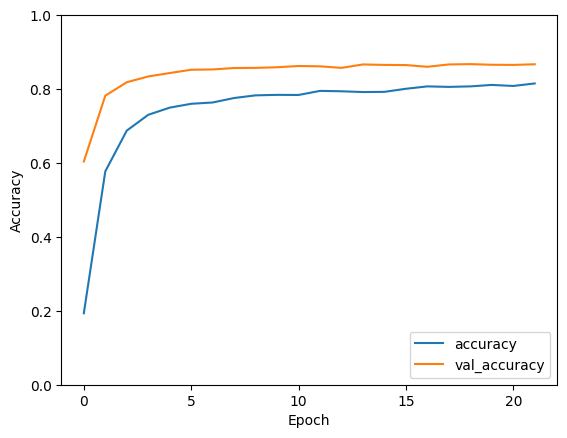

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_generator, verbose=2)

In [ ]:
model.save('stanford-dogs-dataset-InceptionV3-TL.keras')

# Classification report

In [5]:
model = tf.keras.models.load_model('/content/stanford-dogs-dataset-InceptionV3-TL.keras')

In [43]:
pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred, axis=1)
y_true = test_generator.classes

135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.71      0.80        52
           1       0.93      0.91      0.92        85
           2       0.93      0.88      0.90       152
           3       0.93      0.84      0.88        49
           4       0.83      0.73      0.78       114
           5       0.94      0.95      0.95        88
           6       0.95      0.95      0.95        96
           7       0.79      0.92      0.85        72
           8       0.75      0.71      0.73        72
           9       0.96      0.98      0.97       139
          10       0.82      0.97      0.89        75
          11       0.80      0.77      0.78        95
          12       0.93      0.90      0.91        87
          13       0.94      0.92      0.93        71
          14       0.85      0.80      0.82        59
          15       0.62      0.66      0.64        53
          16       0.72      0.60      0.65        57
          17       0.70    

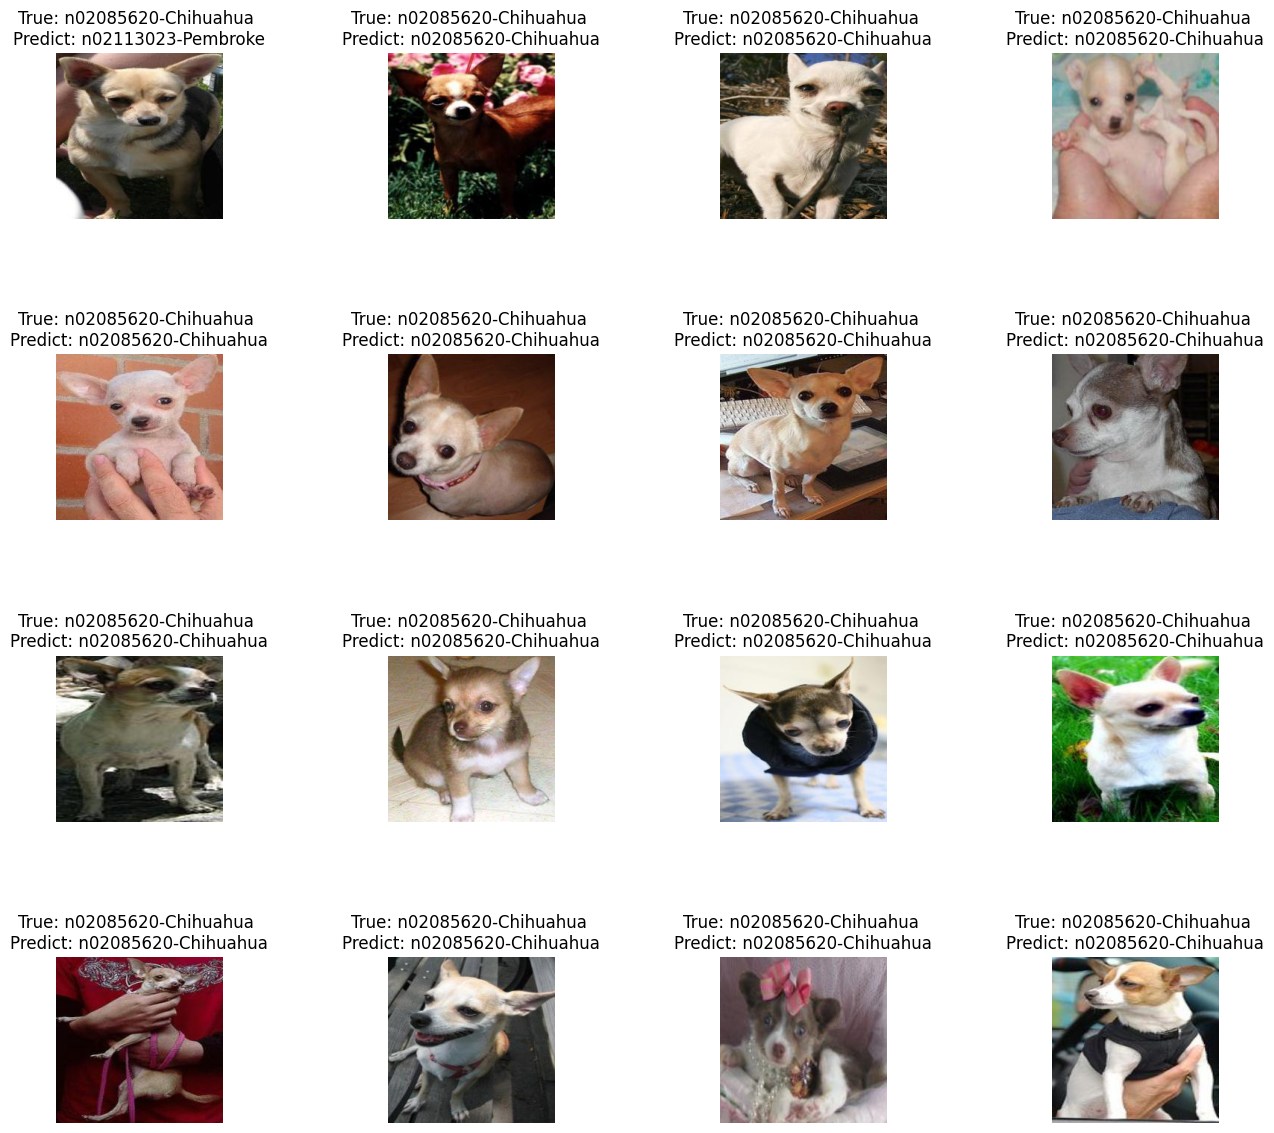

In [76]:
fig, axes = plt.subplots(4, 4, figsize=(15,15))
axes = axes.ravel()
class_labels = list(train_generator.class_indices.keys())

for i in np.arange(16):
    axes[i].imshow(test_generator[0][0][i])
    axes[i].set_title('True: %s \nPredict: %s' % (class_labels[y_true[i]], class_labels[y_pred[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)